#Import important libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

#Importing dataset [link](https://www.kaggle.com/datasets/bandikarthik/movie-recommendation-system/code?select=links.csv)

In [ ]:
links_org = pd.read_csv('/content/drive/MyDrive/dataset/links.csv')
movies_org = pd.read_csv('/content/drive/MyDrive/dataset/movies.csv')
ratings_org = pd.read_csv('/content/drive/MyDrive/dataset/ratings.csv')
tags_org = pd.read_csv('/content/drive/MyDrive/dataset/tags.csv')
links_org

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
34203,151697,62636,76851.0
34204,151701,1773315,235450.0
34205,151703,1507355,58500.0
34206,151709,2436672,365065.0


In [ ]:
movies_org

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
34203,151697,Grand Slam (1967),Thriller
34204,151701,Bloodmoney (2010),(no genres listed)
34205,151703,The Butterfly Circus (2009),Drama
34206,151709,Zero (2015),Drama|Sci-Fi


In [ ]:
ratings_org

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496
...,...,...,...,...
22884372,247753,49530,5.0,1430437962
22884373,247753,69481,3.0,1430437984
22884374,247753,74458,4.0,1430437968
22884375,247753,76093,5.0,1430437811


In [ ]:
tags_org

,userId,movieId,tag,timestamp
0,19,2324,bittersweet,1428651158
1,19,2324,holocaust,1428651112
2,19,2324,World War II,1428651118
3,23,7075,hilarious,1378675786
4,23,7075,Underrated,1378675786
...,...,...,...,...
586989,247751,96655,future,1366041126
586990,247751,96655,robots,1366041128
586991,247753,356,classic,1430438776
586992,247753,356,oscar (best supporting actor),1430438776


In [ ]:
print('Null values count for links is\n',links_org.isnull().sum(),'\n-------------')
print('Null values count for movies is\n',movies_org.isnull().sum(),'\n-------------')
print('Null values count for ratings is\n',ratings_org.isnull().sum(),'\n------------')
print('Null values count for tags is\n',tags_org.isnull().sum())

Null values count for links is
 movieId      0
imdbId       0
tmdbId     296
dtype: int64 
-------------
Null values count for movies is
 movieId    0
title      0
genres     0
dtype: int64 
-------------
Null values count for ratings is
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 
------------
Null values count for tags is
 userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer
links_org.fillna(0,inplace =True)
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(tags_org)
tags = pd.DataFrame(imputer.transform(tags_org), columns = ['userId','movieId','tag','timestamp'])

##Visualization

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


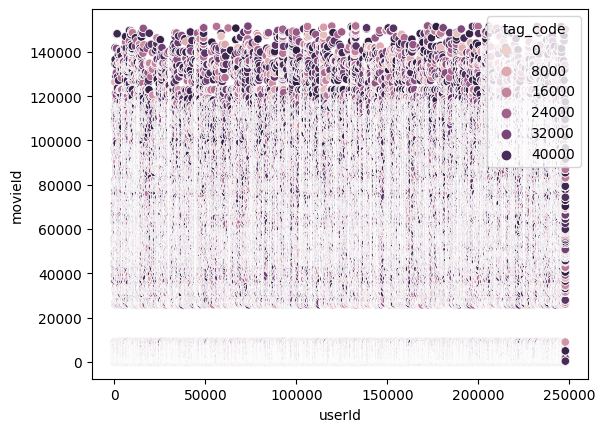

In [ ]:
data_ = tags.copy()
data_['tag'] = pd.Categorical(data_['tag'])
data_['tag_code'] = data_['tag'].cat.codes
111
sns.scatterplot(data=data_, x='userId', y='movieId', hue='tag_code')
plt.show()

#Popularity Based Recommendation

In [ ]:
ratings1 = ratings_org.copy()
ratings1 = ratings1.iloc[0:1000000,:]
ratings1 = ratings1.drop('timestamp', axis = 1)
new = list((ratings1['movieId'].value_counts() <= 10).index)   #Removing movie that has less than 10 number of ratings.
rating1 = ratings1[~ratings1['movieId'].isin(new)]
ratings1

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0
...,...,...,...
999995,10790,6954,5.0
999996,10790,6957,4.0
999997,10790,6991,3.0
999998,10790,7044,4.5


In [ ]:
class popularity_based:
  #Takes Dataset as input used for Recommendation.
  def __init__(self,df1,df2):
    self.df1 = df1
    self.df2 = df2
  #Returns the movies with their IDs according to the genre of the input movie by the user.
  def movie_r(self,a):
    if (a in np.array(self.df1['title'])):
      genre = self.df1[self.df1['title'] == a]['genres'].iloc[0].split('|')
      movies = set()
      for i in range(len(genre)):
        dataset = self.df1[(self.df1['genres']).str.contains(genre[i])]
        mov, movid = np.array(dataset['title']), np.array(dataset['movieId'])
        for j in range(len(mov)):
          movies.add((mov[j],movid[j]))
      return list(movies)
    else:
      p = 'Input Movie not found!!!!!'
      return p
  #Sorts the movies in descending order to the ratings and returns Top n movies.
  def fit(self,a,num):
    mm = self.movie_r(a)
    m,id = [],[]
    for i,j in mm:
      m.append(i)
      id.append(j)
    sets = {}
    for i in id:
      rat = np.mean(self.df2[self.df2['movieId'] == i]['rating'])     #Taking mean rating of each movie by using all ratings given by different users.
      sets[i] = rat
    sets = list(sorted(sets.items(), key=lambda x:x[1]))[::-1]        #Sorting movies in Descending order according to the rating.
    result = []
    k=0
    for i,j in sets:
      if k==num:
        break
      k += 1
      x,z = m[id.index(i)],j
      result.append((x))
    return result

In [ ]:
e = popularity_based(movies_org,ratings1)
a1 = e.fit('Toy Story (1995)',10)
a2 = e.fit('Iron Man (2008)',10)
a3 = e.fit("Walking Dead, The (1995)",10)
print('Top 10 Recommended Movies are -> ')
a1

Top 10 Recommended Movies are -> 


['Manichitrathazhu (1993)',
 'Teen Vamp (1988)',
 "The Stranger's Return (1933)",
 'Further Adventures of the Wilderness Family (1978)',
 'Grand Day Out with Wallace and Gromit, A (1989)',
 'Cold Comfort Farm (1995)',
 'Mega Shark vs. Crocosaurus (2010)',
 'Courage of Lassie (1946)',
 'War Arrow (1954)',
 'Turning Tide (En solitaire) (2013)']

In [ ]:
a2    # "Iron Man"

['One of Our Aircraft Is Missing (1942)',
 'Sol (2012) ',
 'Further Adventures of the Wilderness Family (1978)',
 'Grand Day Out with Wallace and Gromit, A (1989)',
 'Asphyx, The (1973)',
 'Circle (2015)',
 'Mega Shark vs. Crocosaurus (2010)',
 'Rise: Blood Hunter (2007)',
 'Courage of Lassie (1946)',
 'Cat Run 2 (2014)']

In [ ]:
a3 # user input : "Walking Dead, The (1995)"

['Shoot the Moon (1982)',
 'One of Our Aircraft Is Missing (1942)',
 'The Sins of Rachel Cade (1961)',
 "The Stranger's Return (1933)",
 'Guncrazy (1992)',
 'Courage of Lassie (1946)',
 'Ciel est à vous, Le (Woman Who Dared, The) (1944)',
 'War Arrow (1954)',
 'Turning Tide (En solitaire) (2013)',
 'Lowlands (Tiefland) (1954)']

#Colabrative Filtering

##Method 1

In [ ]:
class colabrative_m1:
    def __init__(self,n_movies_to_recommend=10):
      self.n_movies_to_recommend = n_movies_to_recommend

    def fit(self,movies_org,ratings_org):
      self.movies_org = movies_org
      self.ratings_org = ratings_org

      self.ratings = self.ratings_org.copy()      # made the cpy of original dataset
      self.movies = self.movies_org.copy()
      self.ratings_rd = self.ratings.iloc[0:2000000,:]    # reduced the size of data

      self.final_dataset = pd.crosstab(index=self.ratings_rd['movieId'], columns=self.ratings_rd['userId'], values=self.ratings_rd['rating'], aggfunc='first')
      self.final_dataset.fillna(0,inplace=True)       # made the pivote data

      self.csr_data = csr_matrix(self.final_dataset.values)   # made the csr matrix from pivot data
      self.final_dataset.reset_index(inplace=True)

    def get_movie_recommendation(self,movie_name):
        movie_list = self.movies[self.movies['title'].str.contains(movie_name)]     # extract the all movies which contains the user input movie name
        if len(movie_list) == 0:
            return "No movies found. Please check your input"

        movie_idx = movie_list.iloc[0]['movieId']         # Extracting the movieId
        movie_idx = self.final_dataset[self.final_dataset['movieId'] == movie_idx].index[0]
        knn = NearestNeighbors(n_neighbors=self.n_movies_to_recommend+1).fit(self.csr_data)     # train the KNN using the csr matrix
        distances, indices = knn.kneighbors(self.csr_data[movie_idx])     # predicting the movies

        rec_movie_indices = indices[0][1:]    # removing the first movie index as it is same as user input movie

        recommend_frame = []      # to make the dataframe of recommended movies by extracting the titles of movies of corr. indices
        for i, idx in enumerate(rec_movie_indices):
            movie_idx = self.final_dataset.iloc[idx]['movieId']
            title = self.movies[self.movies['movieId'] == movie_idx]['title'].values[0]
            distance = distances[0][i+1]
            recommend_frame.append({'Title': title, 'Distance': distance})

        return pd.DataFrame(recommend_frame, index=range(1, self.n_movies_to_recommend+1))


In [ ]:
model1 = colabrative_m1(15)
model1.fit(movies_org,ratings_org)

In [ ]:
print("Reduced Rating Dataset :\n",model1.ratings_rd)

Reduced Rating Dataset :
          userId  movieId  rating   timestamp
0             1      169     2.5  1204927694
1             1     2471     3.0  1204927438
2             1    48516     5.0  1204927435
3             2     2571     3.5  1436165433
4             2   109487     4.0  1436165496
...         ...      ...     ...         ...
1999995   21530      541     3.5  1175969344
1999996   21530      551     4.0  1439178392
1999997   21530      553     4.0  1175919775
1999998   21530      586     1.5  1174203696
1999999   21530      587     1.5  1174198350

[2000000 rows x 4 columns]


In [ ]:
print("New Dataframe :\n",model1.final_dataset)

New Dataframe :
 userId  movieId    1    2    3    4    5    6    7    8    9  ...  21521  \
0             1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
1             2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
2             3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
3             4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
4             5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
20044    151507  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
20045    151547  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
20046    151593  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
20047    151657  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
20048    151661  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

userId  21522  21523  21524  21525  21526  21527  21528  21529  21530 

In [ ]:
print("CSR data :\n",model1.csr_data)

CSR data :
   (0, 14)	4.0
  (0, 16)	5.0
  (0, 22)	5.0
  (0, 27)	4.0
  (0, 33)	3.0
  (0, 36)	4.5
  (0, 39)	4.0
  (0, 46)	4.0
  (0, 49)	4.0
  (0, 55)	3.0
  (0, 56)	2.0
  (0, 57)	4.0
  (0, 58)	3.0
  (0, 63)	3.0
  (0, 65)	5.0
  (0, 74)	5.0
  (0, 84)	4.0
  (0, 89)	3.0
  (0, 93)	5.0
  (0, 98)	4.5
  (0, 105)	2.5
  (0, 106)	4.0
  (0, 113)	3.0
  (0, 114)	4.5
  (0, 115)	4.0
  :	:
  (20026, 6156)	4.0
  (20026, 14061)	3.5
  (20026, 20854)	3.0
  (20027, 15856)	4.5
  (20028, 10528)	2.5
  (20029, 12598)	2.0
  (20030, 12598)	3.5
  (20031, 12598)	2.5
  (20032, 12598)	2.0
  (20033, 12598)	2.0
  (20034, 18170)	4.0
  (20035, 1501)	3.0
  (20036, 1501)	4.0
  (20037, 9796)	3.0
  (20038, 10230)	5.0
  (20039, 10216)	3.0
  (20040, 12949)	1.5
  (20041, 6261)	3.5
  (20042, 10995)	3.5
  (20043, 10356)	4.5
  (20044, 9100)	3.0
  (20045, 20854)	4.0
  (20046, 12911)	3.0
  (20047, 20784)	5.0
  (20048, 20784)	3.5


In [ ]:
print(model1.get_movie_recommendation('Toy Story'))

                                         Title    Distance
1                           Toy Story 2 (1999)  251.053281
2   Willy Wonka & the Chocolate Factory (1971)  254.365387
3                   Mission: Impossible (1996)  255.814386
4         Independence Day (a.k.a. ID4) (1996)  256.938709
5                               Twister (1996)  258.670640
6                         Bug's Life, A (1998)  262.207933
7             Men in Black (a.k.a. MIB) (1997)  263.326793
8                         Groundhog Day (1993)  264.856565
9                        Monsters, Inc. (2001)  266.778935
10                       Lion King, The (1994)  267.582697
11                 Nutty Professor, The (1996)  267.830637
12                         Finding Nemo (2003)  268.597748
13                            Rock, The (1996)  268.659636
14                            Mask, The (1994)  268.744302
15                        Jerry Maguire (1996)  268.908907


In [ ]:
print(model1.get_movie_recommendation('Iron Man'))

                                        Title    Distance
1                           Iron Man 2 (2010)  129.271033
2                            Star Trek (2009)  131.923273
3                      Sherlock Holmes (2009)  135.791200
4                        Avengers, The (2012)  135.944842
5                         Transformers (2007)  138.122228
6                          I Am Legend (2007)  138.188277
7                             Watchmen (2009)  138.744369
8                   X-Men: First Class (2011)  138.792111
9                                 Thor (2011)  140.074980
10                              Avatar (2009)  140.482205
11                          Iron Man 3 (2013)  140.487544
12                       Kung Fu Panda (2008)  140.564932
13                       Casino Royale (2006)  140.639610
14  Captain America: The First Avenger (2011)  140.713361
15                               Taken (2008)  141.113430


In [ ]:
print(model1.get_movie_recommendation('Walking Dead'))

                                                Title   Distance
1                                 Blood Games (1990)   12.708265
2                               Helter Skelter (1976)  12.718097
3   Mike Birbiglia: What I Should Have Said Was No...  12.737739
4   Whitey: United States of America v. James J. B...  12.747549
5          World, the Flesh and the Devil, The (1959)  12.747549
6                                 Dead Silence (1997)  12.747549
7                                   Wild River (1960)  12.747549
8                             Beneath the Dark (2010)  12.767145
9                              Substitute, The (1993)  12.776932
10                                   Holocaust (1978)  12.776932
11  Bobcat Goldthwait: You Don't Look the Same Eit...  12.776932
12                                   Dark Tide (2012)  12.806248
13   American Kickboxer (American Kickboxer 1) (1991)  12.806248
14                     Attila (Attila the Hun) (1954)  12.806248
15                       

##Method 2

In [ ]:
class collaborative_2:
  #Takes original dataset
  def __init__(self,link,rating,movie,tag):
    self.links = link
    self.ratings = rating.iloc[:100000,]
    self.movies = movie
    self.tags = tag

    #Merge movies and ratings dataset and dropping genres and timestamp column
    self.data = pd.merge(self.movies, self.ratings)
    self.data.drop(['genres','timestamp'],axis = 1)

    #Created user vs movie matrix
    user_ratings = self.data.pivot_table(index = ['userId'],columns = ['title'],values = 'rating')
    user_ratings = user_ratings.fillna(0)
    self.item_similarity = user_ratings.corr(method = 'pearson')

  #Sorted movies according to correlation values
  def get_movies(self, movie_name, user_rating):
    similar_score = self.item_similarity[movie_name]*(user_rating - 2.5)
    similar_score = similar_score.sort_values(ascending = False)
    return similar_score

  #Recommend movie according to movie name and rating given by user
  def recommend(self, movie_name, rating):
    if movie_name not in np.array(self.movies['title']):
      print("Not found")
      return

    #Correlation matrix (method pearson)

    movies_ = self.get_movies(movie_name,rating)
    mov, corr = np.array(list(movies_.index)), np.array(movies_)
    print("Top 10 recommended movies are(with correlation value):")
    for i in range(min(10, len(movies_))):
      print(mov[i], corr[i])

In [ ]:
sys = collaborative_2(links_org.copy(),ratings_org.copy(),movies_org.copy(),tags_org.copy())
sys.recommend("Toy Story (1995)",5)

Top 10 recommended movies are(with correlation value):
Toy Story (1995) 2.5
Lion King, The (1994) 1.1110902661186373
Toy Story 2 (1999) 1.1082703136840713
Mission: Impossible (1996) 1.0604615648715883
Groundhog Day (1993) 1.0362646711370025
Aladdin (1992) 0.9820566614349058
Independence Day (a.k.a. ID4) (1996) 0.9816008144164033
Back to the Future (1985) 0.9766680419748562
Men in Black (a.k.a. MIB) (1997) 0.9526952561363445
Monsters, Inc. (2001) 0.9484369504565936


In [ ]:
sys.recommend("Iron Man (2008)",5)

Top 10 recommended movies are(with correlation value):
Iron Man (2008) 2.5
Star Trek (2009) 1.4606348820566082
Bourne Ultimatum, The (2007) 1.4341336600079413
Sherlock Holmes (2009) 1.4145812117529806
Dark Knight, The (2008) 1.3973476120176889
Casino Royale (2006) 1.3797029062933257
Iron Man 2 (2010) 1.3443843731680538
300 (2007) 1.3067403969393991
Batman Begins (2005) 1.2806428691506924
Avatar (2009) 1.259574246626478


In [ ]:
sys.recommend("Walking Dead, The (1995)",5)

Top 10 recommended movies are(with correlation value):
One Percent, The (2006) 2.500000000000002
Heckler (2007) 2.500000000000002
Halloween Tree, The (1993) 2.500000000000002
Hamburger Hill (1987) 2.500000000000002
Aziz Ansari: Live at Madison Square Garden (2015) 2.500000000000002
Aziz Ansari: Intimate Moments for a Sensual Evening (2010) 2.500000000000002
Aziz Ansari: Dangerously Delicious (2012) 2.500000000000002
Hand, The (1981) 2.500000000000002
Happily N'Ever After (2007) 2.500000000000002
Happy Endings (2005) 2.500000000000002
